In [ ]:
'''
VERSION 1 OF A U-Net MODEL
'''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir myData

!unzip -uq "/content/drive/MyDrive/Colab Notebooks/labels.zip" -d "/content/myData"
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/og_imgs.zip" -d "/content/myData"

In [ ]:
import glob
from PIL import Image


import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
#from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
IMG_WIDTH = 96
IMG_HEIGHT = 256
IMG_CHANNELS = 1

TRAIN_PATH = '/content/myData/og_imgs/'
TEST_PATH = '/content/myData/labels/'

train_image_files = glob.glob(os.path.join(TRAIN_PATH, '*.tif'))
just_name_train_image_files = [os.path.basename(file) for file in train_image_files]


test_image_subfolders = [subfolder for subfolder in os.listdir(TEST_PATH) if os.path.isdir(os.path.join(TEST_PATH, subfolder))]

In [ ]:
X = np.zeros((len(train_image_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
y = np.zeros((len(train_image_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
cnt = 0

for subfolder in test_image_subfolders:
    subfolder_path = os.path.join(TEST_PATH, subfolder)

    # Load masks
    im1_file = glob.glob(os.path.join(subfolder_path, 'label.png'))
    im1 = tf.keras.preprocessing.image.load_img(im1_file[0], grayscale=True)

    mask = tf.keras.preprocessing.image.img_to_array(im1)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode = 'constant', preserve_range = True)
    y[cnt] = mask/75.0

    # Load images
    im2_file = glob.glob(os.path.join(subfolder_path, 'img.png'))
    im2 = tf.keras.preprocessing.image.load_img(im2_file[0], grayscale=True)

    x_img = tf.keras.preprocessing.image.img_to_array(im2)
    x_img = resize(x_img, (IMG_HEIGHT, IMG_WIDTH, 1), mode = 'constant', preserve_range = True)
    X[cnt] = x_img/255.0

    cnt +=1

/usr/local/lib/python3.10/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [ ]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(178, 256, 96, 1)
(178, 256, 96, 1)
(45, 256, 96, 1)
(45, 256, 96, 1)


Text(0.5, 1.0, 'Regions')

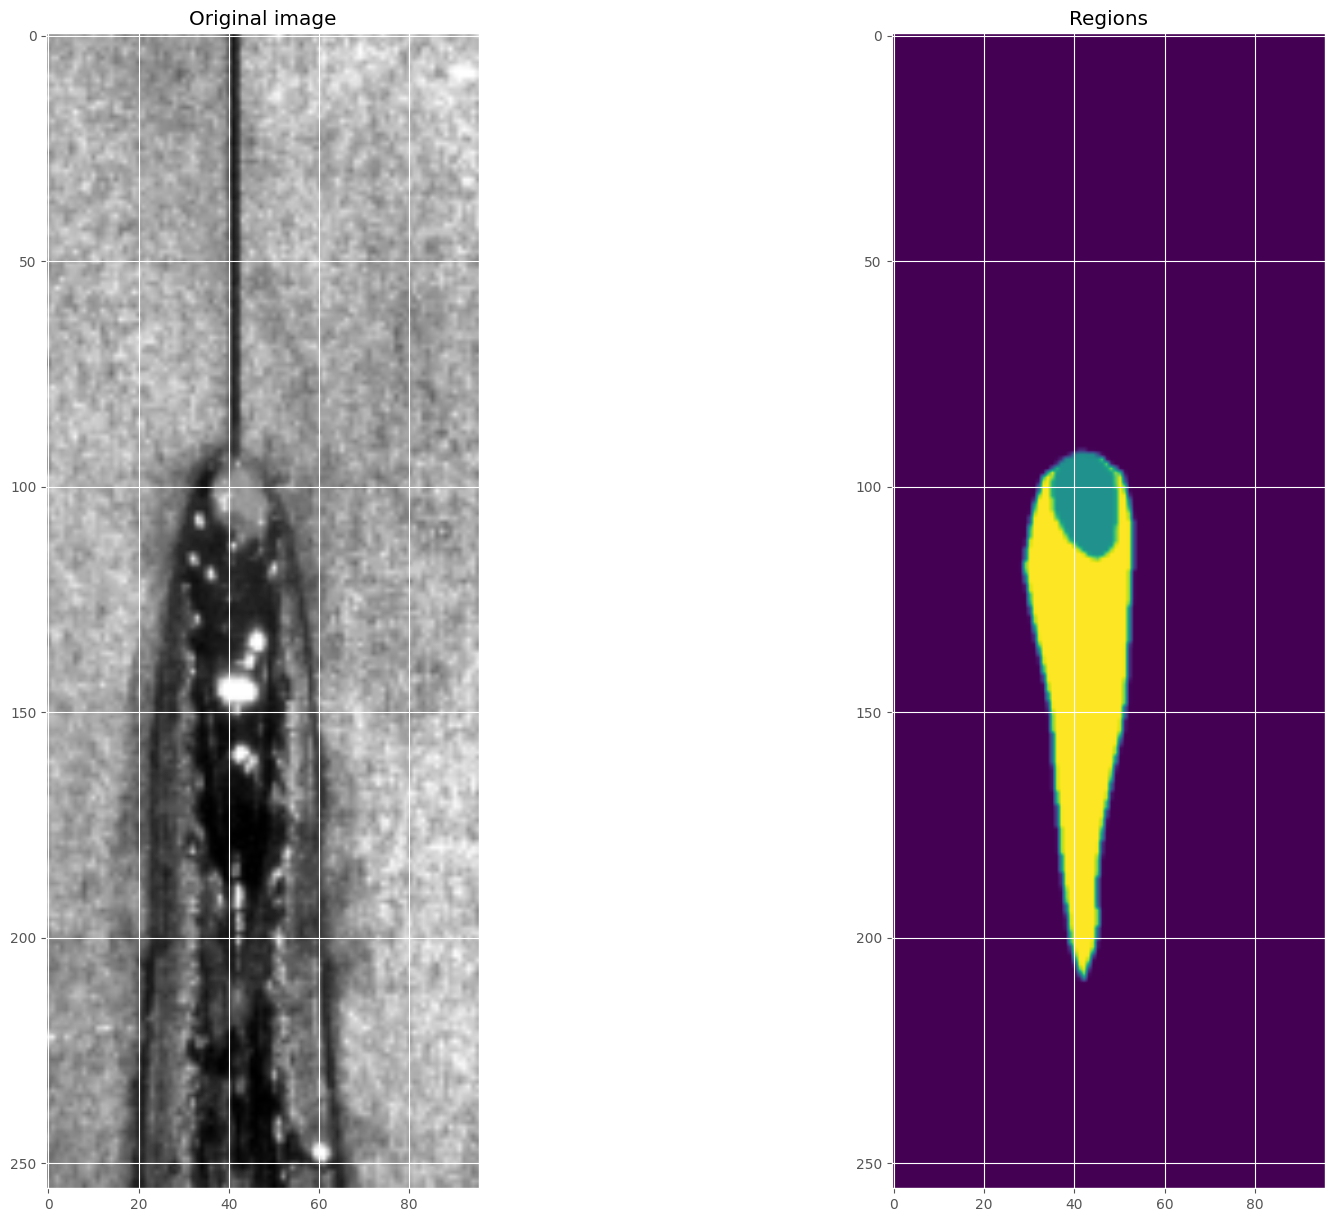

In [ ]:
# Visualize any random image along with the mask
ix = random.randint(0, len(X_train))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
#ax1.imshow(X_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax1.set_title('Original image')

ax2.imshow(y_train[ix], interpolation = 'bilinear')
ax2.set_title('Regions')

In [ ]:

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#Contraction path
c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)

b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)

b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)

c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)

c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)

c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.2)(c5)
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(b5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(r5)
u6 = tf.keras.layers.concatenate([u6, c4])
u6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
u6 = tf.keras.layers.Dropout(0.2)(u6)
u6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)

u6 = tf.keras.layers.BatchNormalization()(u6)
u6 = tf.keras.layers.ReLU()(u6)


u7 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tf.keras.layers.concatenate([u7, c3])
u7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
u7 = tf.keras.layers.Dropout(0.2)(u7)
u7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)

u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)


u8 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tf.keras.layers.concatenate([u8, c2])
u8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
u8 = tf.keras.layers.Dropout(0.2)(u8)
u8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)

u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)


u9 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1])
u9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
u9 = tf.keras.layers.Dropout(0.2)(u9)
u9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)

u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)


outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(u9)

In [ ]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#tf.keras.utils.plot_model(model, "model.png")
#model.summary()

'''callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('model-checkpoint', verbose=1, save_best_only=True, save_weights_only=True)
]'''

"callbacks = [\n    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),\n    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),\n    tf.keras.callbacks.ModelCheckpoint('model-checkpoint', verbose=1, save_best_only=True, save_weights_only=True)\n]"

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
]

results = model.fit(X_train, y_train, validation_data=(X_valid,y_valid), batch_size=25, epochs=20, callbacks = callbacks)

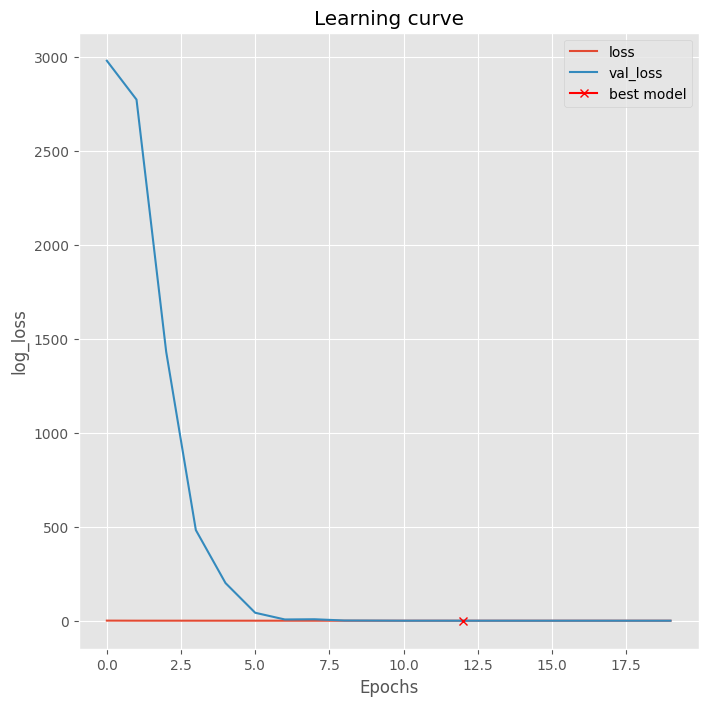

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.3).astype(np.uint8)
preds_val_t = (preds_val > 0.3).astype(np.uint8)

print(X_train.shape)
print(y_train.shape)
print(preds_train.shape)
print(preds_train_t.shape)

2/2 [==============================] - 0s 197ms/step
(178, 256, 96, 1)
(178, 256, 96, 1)
(178, 256, 96, 1)
(178, 256, 96, 1)


In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix].squeeze(), cmap='gray')
    ax[0].set_title('cavitar image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('molten pool')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    ax[2].set_title('Predicted')

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    ax[3].set_title('Predicted binary');

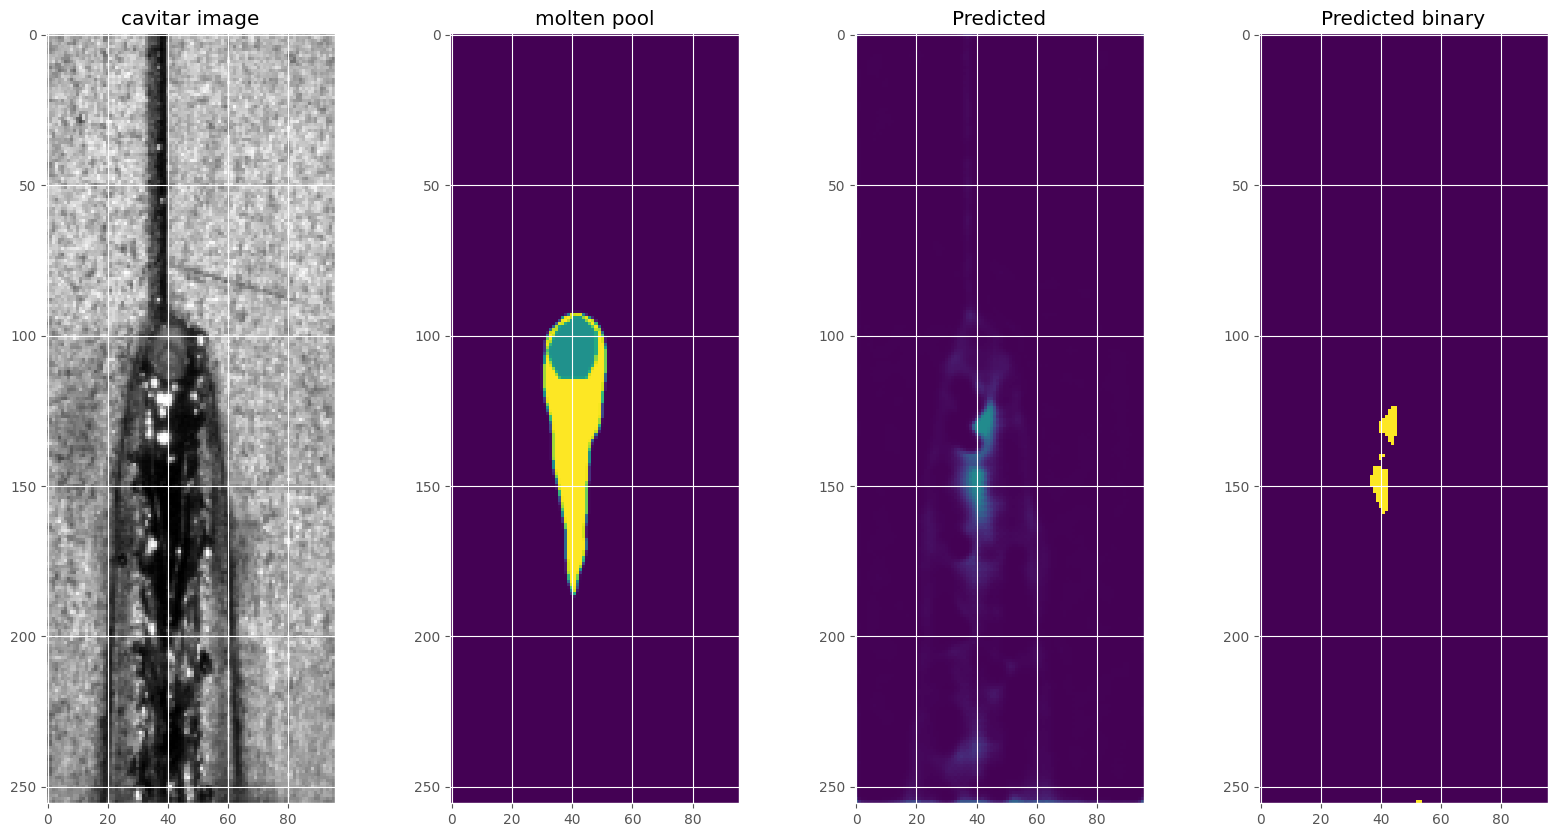

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t)

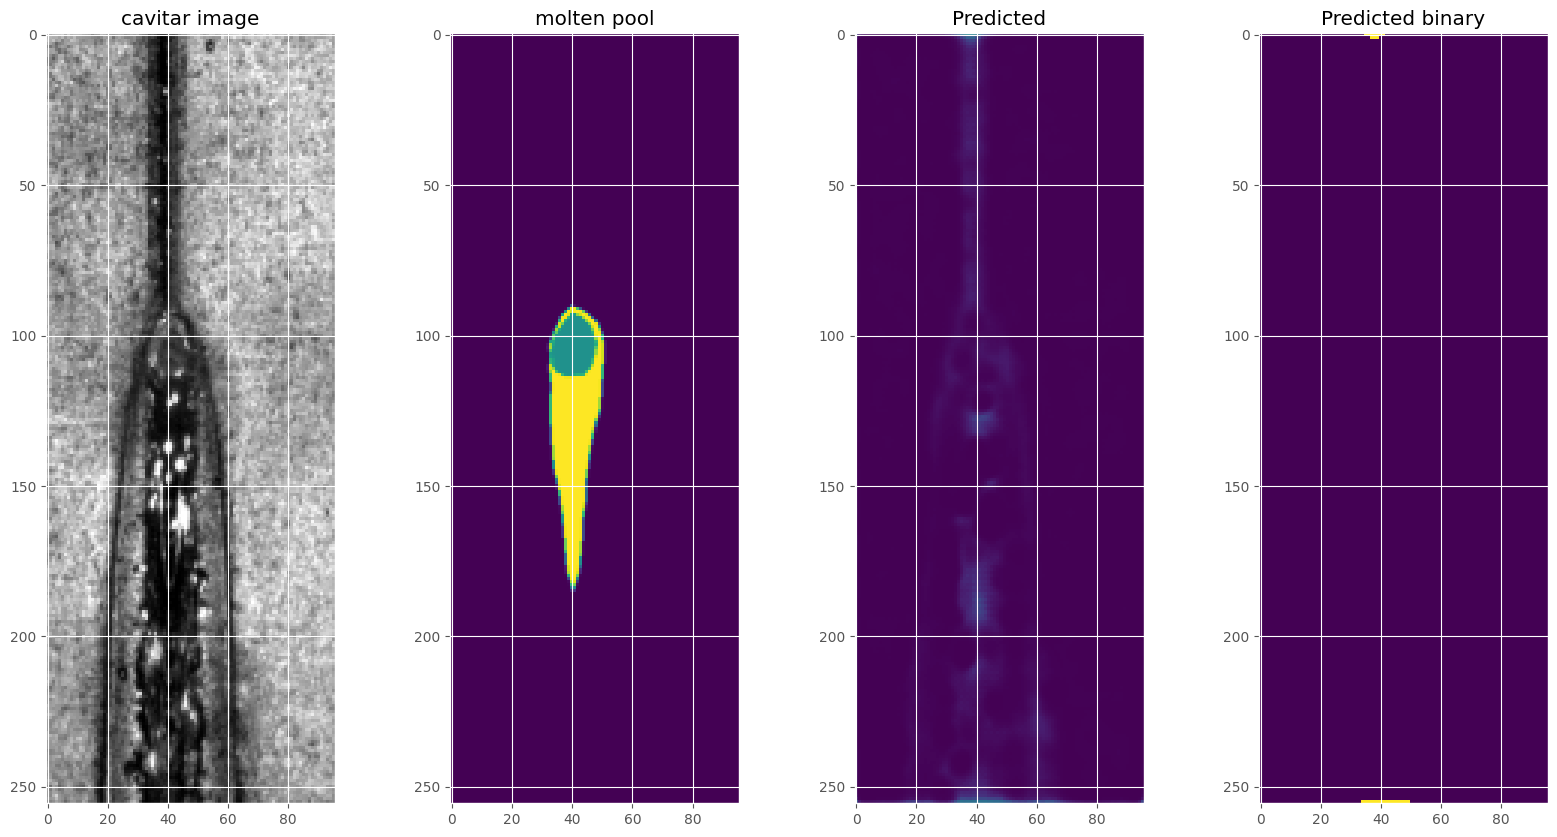

In [ ]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t)